In [6]:
import pandas as pd
import numpy as np
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import matplotlib.pyplot as plt

from time_series_experiments import utils
from time_series_experiments import baseline
from time_series_experiments import transformer

In [2]:
seed = 0xC0FFEE
fdw = 24
fw = 12

air_df = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv')

In [3]:
y = air_df['Passengers'].values

x_train_idx, y_train_idx, x_test_idx, y_test_idx = utils.train_test_split_index(
    y.shape[0], fdw, fw, test_size=0.1, random_seed=seed
)

x_train = np.expand_dims(y[x_train_idx], axis=-1)
y_train = y[y_train_idx]
x_test = np.expand_dims(y[x_test_idx], axis=-1)
y_test = y[y_test_idx]

In [4]:
baseline_model = baseline.LatestNaiveBaseline(fw=fw)
y_pred_baseline = baseline_model.predict(x_test)
utils.rmse(y_test, np.squeeze(y_pred_baseline))

96.54480824984842

In [5]:
# scaler = MinMaxScaler(feature_range=(0.01, 0.99))
scaler = StandardScaler()

xtr, ytr = x_train, y_train 
# xtr, ytr = np.log(xtr), np.log(ytr)
scaler.fit(np.reshape(xtr, (-1, 1)))

xtr = utils.scaler_transform(scaler, xtr)
ytr = utils.scaler_transform(scaler, ytr)


transformer_model = transformer.Transformer(
    num_layers=1,
    attention_dim=4,
    num_heads=4,
    linear_kernel_initializer=utils.get_initializer("glorot_uniform", seed),
    attention_kernel_initializer=utils.get_initializer("glorot_uniform", seed),
    pwffn_kernel_initializer=utils.get_initializer("glorot_uniform", seed),
    output_kernel_initializer=utils.get_initializer("glorot_uniform", seed),
    epochs=100,
    batch_size=32,
    optimizer=keras.optimizers.Adam(0.009),
    loss=keras.losses.MeanAbsoluteError(),
)
history = transformer_model.fit(xtr, ytr, verbose=0)

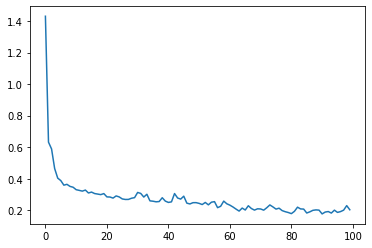

In [9]:
plot_y = np.array(history.history['loss'])
plot_x = np.arange(plot_y.shape[0])
plt.plot(plot_x, plot_y)

In [10]:
xt = x_test
# xt = np.log(xt)
xt = utils.scaler_transform(scaler, xt)

y_pred, _ = transformer_model.predict(xt)
y_pred = scaler.inverse_transform(y_pred)
# y_pred = np.exp(y_pred)

'RMSE', utils.rmse(y_test, y_pred), 'MASE', utils.mase(y_test, y_pred, np.squeeze(y_pred_baseline))

('RMSE', 58.18955606640669, 'MASE', 0.586420708823626)

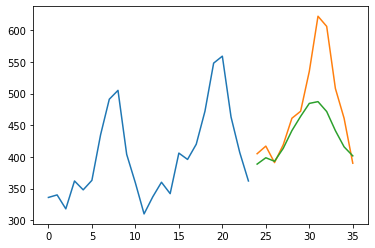

In [19]:
random_element = np.random.randint(y_pred.shape[0])
plot_x = np.squeeze(x_test[random_element])
plot_y_pred = np.squeeze(y_pred[random_element])
plot_y = np.squeeze(y_test[random_element])

plot_x_numbers = np.arange(0, plot_x.shape[0])
plot_y_numbers = np.arange(plot_x.shape[0], plot_x.shape[0] + plot_y.shape[0])

plt.plot(plot_x_numbers, plot_x)
plt.plot(plot_y_numbers, plot_y)
plt.plot(plot_y_numbers, plot_y_pred)